<a href="https://colab.research.google.com/github/lilyzhizhou/Datathon-5/blob/main/Datathon_5_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
import torch as t
import torch.nn as nn
import random
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if t.cuda.is_available()
    else "mps"
    if t.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Load in data
# data = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #5/mhealth.csv')
data = pd.read_csv('mhealth.csv')

# drop subject 9 bc their distribution is different from the others
data = data[data['subject'] != 'subject9']

print(data.shape)
data.head()

(982273, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [5]:
data.dtypes

alx         float64
aly         float64
alz         float64
glx         float64
gly         float64
glz         float64
arx         float64
ary         float64
arz         float64
grx         float64
gry         float64
grz         float64
Activity      int64
subject      object
dtype: object

Split into Training and Testing


---



In [6]:
# Grouping by 'subject' and creating a list of dataframes, one per group
grouped = data.groupby('subject')
grouped_data = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_data, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((753408, 14), (228865, 14))

In [7]:
# train_df.head()
test_df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
161280,0.49965,-9.6680,1.5216,-0.47866,-0.53471,0.53438,-4.6451,-8.2508,1.9208,-0.98039,-0.41889,0.18966,0,subject2
161281,0.40572,-9.5801,1.4001,-0.48423,-0.54409,0.52652,-4.7847,-8.2609,1.9099,-0.98039,-0.41889,0.18966,0,subject2
161282,0.42741,-9.6488,1.4593,-0.48423,-0.54409,0.52652,-4.4974,-8.3198,2.0215,-0.97647,-0.42094,0.20043,0,subject2
161283,0.32193,-9.4522,1.3119,-0.48423,-0.54409,0.52652,-4.6902,-8.4318,1.8180,-0.97647,-0.42094,0.20043,0,subject2
161284,0.46731,-9.6397,1.3769,-0.49165,-0.52345,0.51866,-4.7595,-8.4420,1.7966,-0.97647,-0.42094,0.20043,0,subject2


Normalization

---



In [8]:
# Identifying numerical columns (excluding 'subject' and 'Activity')
numerical_columns = train_df.select_dtypes(include=['float64']).columns.tolist()

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Checking the first few rows of the normalized training data
print(train_df.shape)
train_df.head()

(753408, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,0.214821,-0.022355,0.309939,0.244241,-0.668159,-1.036175,-1.098917,0.233330,-0.594683,-0.335191,-1.016340,-0.471094,0,subject1
1,0.267516,0.023418,0.319902,0.207517,-0.662733,-1.028975,-1.094306,0.278958,-0.636633,-0.335191,-1.016340,-0.471094,0,subject1
2,0.272975,0.009010,0.319384,0.207517,-0.662733,-1.028975,-1.069191,0.286484,-0.572206,-0.335191,-1.016340,-0.471094,0,subject1
3,0.213911,0.042315,0.294847,0.207517,-0.662733,-1.028975,-1.094388,0.279577,-0.548748,-0.349689,-1.012564,-0.486675,0,subject1
4,0.275237,0.052309,0.324983,0.207517,-0.662733,-1.028975,-1.109395,0.309677,-0.538585,-0.349689,-1.012564,-0.486675,0,subject1


Sequence Creation & Addressing Class Imbalance

---



In [9]:
# Sequence creation for data (with undersampling for train data)
sensor_columns = ['alx','aly','alz','glx','gly','glz','arx','ary','arz','grx','gry','grz']

def create_sequences(data, sequence_length=100, train = True):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        # We label the sequence with the most intense activity within the sequence
        label = sequence['Activity'].max()

        # Undersampling label 0 for train data only
        if train == False or (label != 0 or random.random() > 0.95): # undersample the 0 labels where there is a 95% chance to drop
          sequences.append(sequence[sensor_columns].values)
          output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=100, train = True)
X_test, y_test = create_sequences(test_df, sequence_length=100, train = False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2420, 100, 12), (2420,), (2288, 100, 12), (2288,))

<Axes: ylabel='Count'>

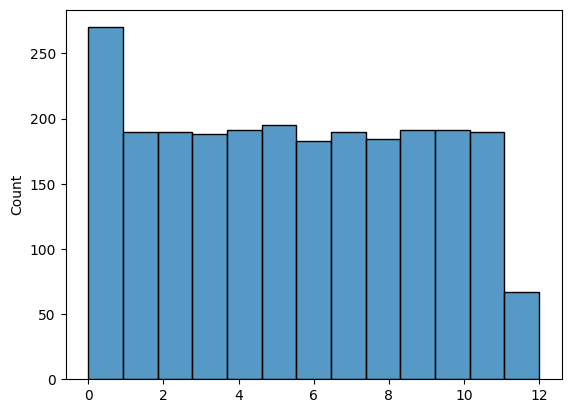

In [10]:
import seaborn as sns
# for i in range(len(y_train)):
#   print(y_train[i])

sns.histplot(y_train)

Training data looks more balanced now

Run LSTM Model

---



- will need to tune parameters
- not sure what to set as hidden_size

In [11]:
class lstmModel(nn.Module): # Model inherits from nn.Module
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True) # LSTM layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out.max(1)[0])
        return nn.functional.log_softmax(out, dim=1)

In [12]:
def modelLoop(epochs, hidden_dim, learning_rate, batch_size):

    # Data preparation
    train_dataset = TensorDataset(t.Tensor(X_train).type(t.float32).to(device), t.Tensor(y_train).type(t.float32).to(device))
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t.Tensor(X_test).type(t.float32).to(device), t.Tensor(y_test).type(t.float32).to(device))
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = lstmModel(input_size=12, hidden_dim = hidden_dim, num_classes = 13).to(device)

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store accuracies and losses
    train_accuracy_list = []
    validation_accuracy_list = []
    train_loss_list = []

    # Training loop
    for epoch in range(epochs+1):
        # if epoch % 10 == 0:
        #     learning_rate *= 0.9  # Learning rate scheduling

        per_epoch_loss_list = []

        # Setting Model to train mode
        model.train()

        for X, Y in train_data_loader:
            Y = Y.type(t.LongTensor)   # casting to long
            X = X.type(t.float32)   # casting to long
            X, Y = X.to(device), Y.to(device)
            # Forward pass through layers
            pred = model(X)
            loss = loss_fn(pred, Y)

            per_epoch_loss_list.append(loss.item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation on training and validation data
        model.eval()
        
        with t.no_grad():
            # Training data
            train_correct, train_total = 0, 0
            for X, Y in train_data_loader:
                y_pred = model(X)
                _, predicted = t.max(y_pred, dim=1)
                train_total += Y.size(0)
                train_correct += (predicted == Y).sum().item()

            train_accuracy = 100 * train_correct / train_total

            # Validation data
            validation_correct, validation_total = 0, 0
            for X, Y in test_data_loader:
                y_pred = model(X)
                _, predicted = t.max(y_pred, dim=1)
                validation_total += Y.size(0)
                validation_correct += (predicted == Y).sum().item()
            validation_accuracy = 100 * validation_correct / validation_total

            # Print accuracy for the current epoch
            # print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

            # Append accuracy values to lists
            train_accuracy_list.append(train_accuracy)
            validation_accuracy_list.append(validation_accuracy)

            # Calculate and append the average loss for the epoch
            train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    return train_accuracy_list, validation_accuracy_list
    

- Not sure if we want only the last output of the sequence if we initially generated it using the max
(out = out[:, -1, :])

- Using the last observation of sequence: Train Accuracy: 68.8%, Validation Accuracy: 27.4%
- Using max observation of sequence Train Accuracy: 95.8%, Validation Accuracy: 56.4%

In [13]:
    
def plot_acc(train_accuracy_list, validation_accuracy_list):
    # Plot training and validation accuracy over epochs
    plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
    plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
    plt.legend(loc="upper left")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

Batch Size: 64, Learning Rate: 0.001, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 10.082644628099173%, Validation Accuracy: 40.2972027972028%
Epoch 10/100 ---> Train Accuracy: 77.1900826446281%, Validation Accuracy: 26.87937062937063%
Epoch 20/100 ---> Train Accuracy: 85.41322314049587%, Validation Accuracy: 46.15384615384615%
Epoch 30/100 ---> Train Accuracy: 93.30578512396694%, Validation Accuracy: 58.61013986013986%
Epoch 40/100 ---> Train Accuracy: 93.67768595041322%, Validation Accuracy: 60.44580419580419%
Epoch 50/100 ---> Train Accuracy: 95.16528925619835%, Validation Accuracy: 63.02447552447553%
Epoch 60/100 ---> Train Accuracy: 95.9090909090909%, Validation Accuracy: 61.84440559440559%
Epoch 70/100 ---> Train Accuracy: 93.88429752066116%, Validation Accuracy: 60.27097902097902%
Epoch 80/100 ---> Train Accuracy: 95.86776859504133%, Validation Accuracy: 60.88286713286713%
Epoch 90/100 ---> Train Accuracy: 95.41322314049587%, Validation Accuracy: 60.53321678321678%
Epoch 100/

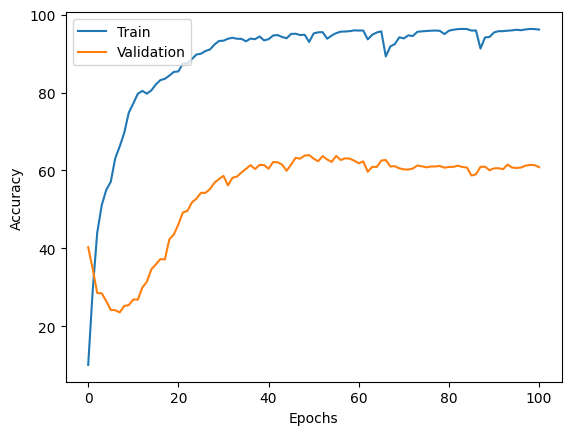

Batch Size: 64, Learning Rate: 0.001, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 32.72727272727273%, Validation Accuracy: 9.265734265734265%
Epoch 10/100 ---> Train Accuracy: 85.99173553719008%, Validation Accuracy: 38.76748251748252%
Epoch 20/100 ---> Train Accuracy: 94.7107438016529%, Validation Accuracy: 55.81293706293706%
Epoch 30/100 ---> Train Accuracy: 94.79338842975207%, Validation Accuracy: 60.22727272727273%
Epoch 40/100 ---> Train Accuracy: 94.83471074380165%, Validation Accuracy: 59.65909090909091%
Epoch 50/100 ---> Train Accuracy: 96.52892561983471%, Validation Accuracy: 63.50524475524475%
Epoch 60/100 ---> Train Accuracy: 96.5702479338843%, Validation Accuracy: 63.50524475524475%
Epoch 70/100 ---> Train Accuracy: 96.98347107438016%, Validation Accuracy: 65.9527972027972%
Epoch 80/100 ---> Train Accuracy: 97.60330578512396%, Validation Accuracy: 65.16608391608392%
Epoch 90/100 ---> Train Accuracy: 97.85123966942149%, Validation Accuracy: 67.17657342657343%
Epoch 100/1

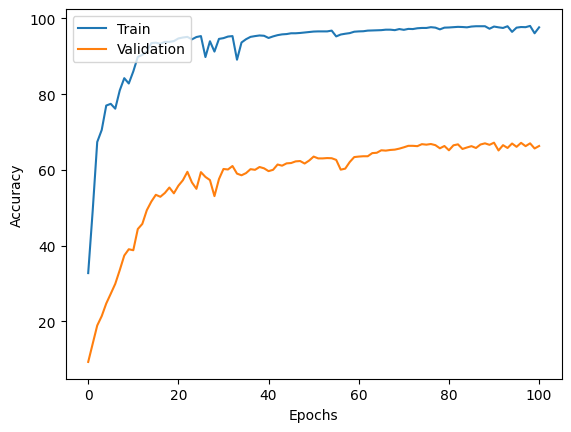

Batch Size: 64, Learning Rate: 0.001, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 53.429752066115704%, Validation Accuracy: 16.17132867132867%
Epoch 10/100 ---> Train Accuracy: 94.79338842975207%, Validation Accuracy: 58.30419580419581%
Epoch 20/100 ---> Train Accuracy: 97.10743801652893%, Validation Accuracy: 62.10664335664335%
Epoch 30/100 ---> Train Accuracy: 96.69421487603306%, Validation Accuracy: 61.62587412587413%
Epoch 40/100 ---> Train Accuracy: 96.98347107438016%, Validation Accuracy: 64.77272727272727%
Epoch 50/100 ---> Train Accuracy: 97.97520661157024%, Validation Accuracy: 66.52097902097903%
Epoch 60/100 ---> Train Accuracy: 98.22314049586777%, Validation Accuracy: 66.95804195804196%
Epoch 70/100 ---> Train Accuracy: 97.76859504132231%, Validation Accuracy: 66.17132867132867%
Epoch 80/100 ---> Train Accuracy: 97.52066115702479%, Validation Accuracy: 65.3409090909091%
Epoch 90/100 ---> Train Accuracy: 98.22314049586777%, Validation Accuracy: 70.1486013986014%
Epoch 100

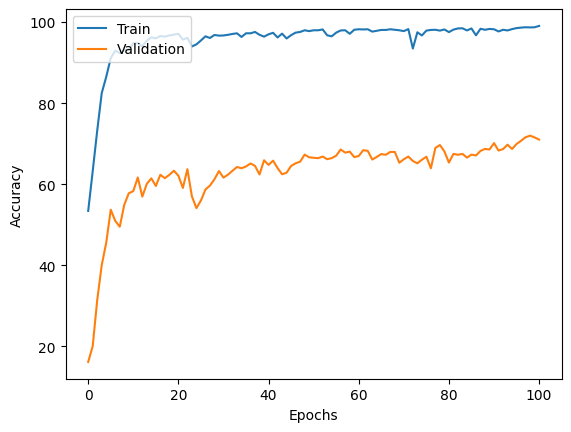

Batch Size: 64, Learning Rate: 0.01, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 70.08264462809917%, Validation Accuracy: 27.403846153846153%
Epoch 10/100 ---> Train Accuracy: 96.28099173553719%, Validation Accuracy: 61.49475524475525%
Epoch 20/100 ---> Train Accuracy: 97.47933884297521%, Validation Accuracy: 68.40034965034965%
Epoch 30/100 ---> Train Accuracy: 97.39669421487604%, Validation Accuracy: 69.23076923076923%
Epoch 40/100 ---> Train Accuracy: 97.89256198347107%, Validation Accuracy: 66.78321678321679%
Epoch 50/100 ---> Train Accuracy: 98.67768595041322%, Validation Accuracy: 69.79895104895105%
Epoch 60/100 ---> Train Accuracy: 98.88429752066116%, Validation Accuracy: 70.45454545454545%
Epoch 70/100 ---> Train Accuracy: 99.21487603305785%, Validation Accuracy: 70.36713286713287%
Epoch 80/100 ---> Train Accuracy: 99.00826446280992%, Validation Accuracy: 69.27447552447552%
Epoch 90/100 ---> Train Accuracy: 98.96694214876032%, Validation Accuracy: 69.5367132867133%
Epoch 100

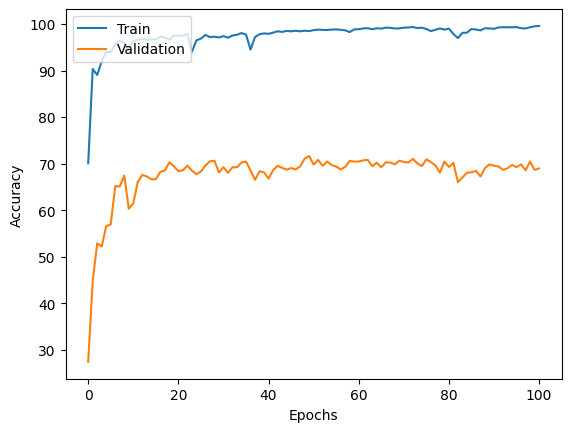

Batch Size: 64, Learning Rate: 0.01, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 77.27272727272727%, Validation Accuracy: 23.95104895104895%
Epoch 10/100 ---> Train Accuracy: 97.60330578512396%, Validation Accuracy: 69.23076923076923%
Epoch 20/100 ---> Train Accuracy: 98.26446280991736%, Validation Accuracy: 69.88636363636364%
Epoch 30/100 ---> Train Accuracy: 98.92561983471074%, Validation Accuracy: 69.84265734265735%
Epoch 40/100 ---> Train Accuracy: 98.59504132231405%, Validation Accuracy: 70.54195804195804%
Epoch 50/100 ---> Train Accuracy: 97.68595041322314%, Validation Accuracy: 73.81993006993007%
Epoch 60/100 ---> Train Accuracy: 99.17355371900827%, Validation Accuracy: 72.55244755244755%
Epoch 70/100 ---> Train Accuracy: 99.25619834710744%, Validation Accuracy: 72.72727272727273%
Epoch 80/100 ---> Train Accuracy: 99.42148760330579%, Validation Accuracy: 70.06118881118881%
Epoch 90/100 ---> Train Accuracy: 99.46280991735537%, Validation Accuracy: 72.50874125874125%
Epoch 100

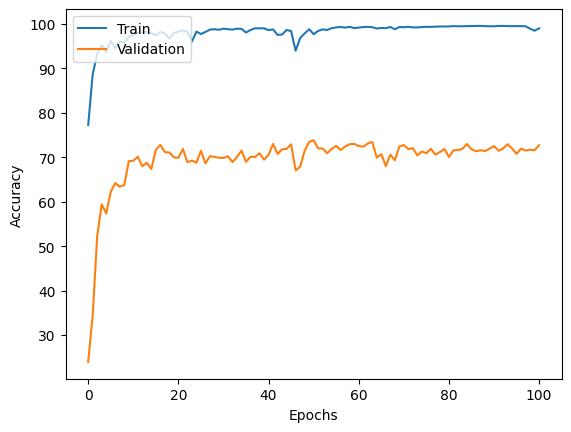

Batch Size: 64, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 87.47933884297521%, Validation Accuracy: 38.8986013986014%
Epoch 10/100 ---> Train Accuracy: 97.47933884297521%, Validation Accuracy: 69.01223776223776%
Epoch 20/100 ---> Train Accuracy: 97.89256198347107%, Validation Accuracy: 72.77097902097903%
Epoch 30/100 ---> Train Accuracy: 99.13223140495867%, Validation Accuracy: 74.03846153846153%
Epoch 40/100 ---> Train Accuracy: 99.29752066115702%, Validation Accuracy: 73.38286713286713%
Epoch 50/100 ---> Train Accuracy: 99.54545454545455%, Validation Accuracy: 72.1590909090909%
Epoch 60/100 ---> Train Accuracy: 99.46280991735537%, Validation Accuracy: 73.33916083916084%
Epoch 70/100 ---> Train Accuracy: 98.59504132231405%, Validation Accuracy: 68.0944055944056%
Epoch 80/100 ---> Train Accuracy: 99.58677685950413%, Validation Accuracy: 70.54195804195804%
Epoch 90/100 ---> Train Accuracy: 99.54545454545455%, Validation Accuracy: 69.71153846153847%
Epoch 100/10

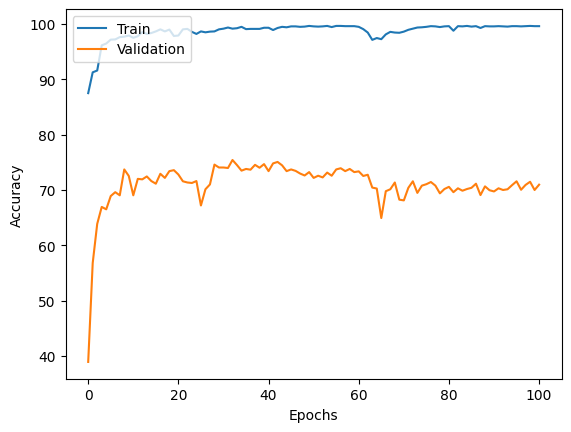

Batch Size: 64, Learning Rate: 0.1, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 91.03305785123968%, Validation Accuracy: 46.59090909090909%
Epoch 10/100 ---> Train Accuracy: 84.83471074380165%, Validation Accuracy: 33.61013986013986%
Epoch 20/100 ---> Train Accuracy: 89.0495867768595%, Validation Accuracy: 41.17132867132867%
Epoch 30/100 ---> Train Accuracy: 77.47933884297521%, Validation Accuracy: 29.58916083916084%
Epoch 40/100 ---> Train Accuracy: 65.70247933884298%, Validation Accuracy: 37.06293706293706%
Epoch 50/100 ---> Train Accuracy: 80.70247933884298%, Validation Accuracy: 46.37237762237762%
Epoch 60/100 ---> Train Accuracy: 87.14876033057851%, Validation Accuracy: 43.40034965034965%
Epoch 70/100 ---> Train Accuracy: 87.97520661157024%, Validation Accuracy: 44.31818181818182%
Epoch 80/100 ---> Train Accuracy: 87.97520661157024%, Validation Accuracy: 49.91258741258741%
Epoch 90/100 ---> Train Accuracy: 88.14049586776859%, Validation Accuracy: 38.72377622377623%
Epoch 100/1

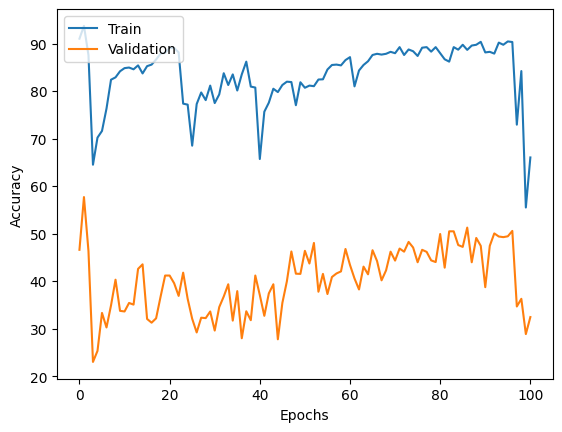

Batch Size: 64, Learning Rate: 0.1, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 90.08264462809917%, Validation Accuracy: 56.25%
Epoch 10/100 ---> Train Accuracy: 82.68595041322314%, Validation Accuracy: 31.905594405594407%
Epoch 20/100 ---> Train Accuracy: 57.1900826446281%, Validation Accuracy: 33.56643356643357%
Epoch 30/100 ---> Train Accuracy: 84.00826446280992%, Validation Accuracy: 41.17132867132867%
Epoch 40/100 ---> Train Accuracy: 85.37190082644628%, Validation Accuracy: 45.93531468531469%
Epoch 50/100 ---> Train Accuracy: 80.37190082644628%, Validation Accuracy: 32.56118881118881%
Epoch 60/100 ---> Train Accuracy: 82.56198347107438%, Validation Accuracy: 39.37937062937063%
Epoch 70/100 ---> Train Accuracy: 85.6198347107438%, Validation Accuracy: 44.14335664335665%
Epoch 80/100 ---> Train Accuracy: 82.43801652892562%, Validation Accuracy: 46.80944055944056%
Epoch 90/100 ---> Train Accuracy: 84.79338842975207%, Validation Accuracy: 35.92657342657343%
Epoch 100/100 ---> Trai

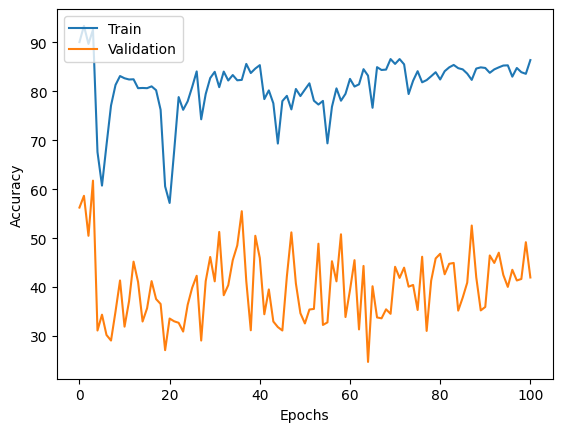

Batch Size: 64, Learning Rate: 0.1, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 90.04132231404958%, Validation Accuracy: 44.36188811188811%
Epoch 10/100 ---> Train Accuracy: 74.87603305785125%, Validation Accuracy: 53.54020979020979%
Epoch 20/100 ---> Train Accuracy: 81.28099173553719%, Validation Accuracy: 53.32167832167832%
Epoch 30/100 ---> Train Accuracy: 85.24793388429752%, Validation Accuracy: 42.74475524475525%
Epoch 40/100 ---> Train Accuracy: 81.77685950413223%, Validation Accuracy: 42.78846153846154%
Epoch 50/100 ---> Train Accuracy: 87.39669421487604%, Validation Accuracy: 37.89335664335665%
Epoch 60/100 ---> Train Accuracy: 86.85950413223141%, Validation Accuracy: 34.26573426573427%
Epoch 70/100 ---> Train Accuracy: 79.46280991735537%, Validation Accuracy: 58.95979020979021%
Epoch 80/100 ---> Train Accuracy: 88.05785123966942%, Validation Accuracy: 39.86013986013986%
Epoch 90/100 ---> Train Accuracy: 88.63636363636364%, Validation Accuracy: 41.21503496503497%
Epoch 100/

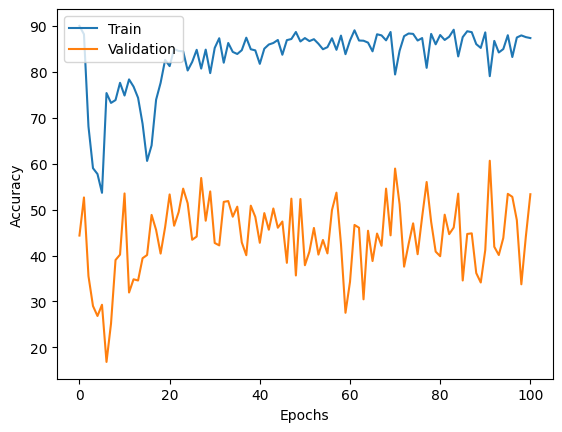

Batch Size: 128, Learning Rate: 0.001, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 14.297520661157025%, Validation Accuracy: 4.851398601398602%
Epoch 10/100 ---> Train Accuracy: 73.22314049586777%, Validation Accuracy: 25.917832167832167%
Epoch 20/100 ---> Train Accuracy: 90.82644628099173%, Validation Accuracy: 40.69055944055944%
Epoch 30/100 ---> Train Accuracy: 92.68595041322314%, Validation Accuracy: 45.8479020979021%
Epoch 40/100 ---> Train Accuracy: 92.43801652892562%, Validation Accuracy: 48.95104895104895%
Epoch 50/100 ---> Train Accuracy: 94.7107438016529%, Validation Accuracy: 51.22377622377623%
Epoch 60/100 ---> Train Accuracy: 94.87603305785125%, Validation Accuracy: 55.02622377622377%
Epoch 70/100 ---> Train Accuracy: 95.24793388429752%, Validation Accuracy: 55.11363636363637%
Epoch 80/100 ---> Train Accuracy: 95.82644628099173%, Validation Accuracy: 56.03146853146853%
Epoch 90/100 ---> Train Accuracy: 96.03305785123968%, Validation Accuracy: 55.68181818181818%
Epoch 1

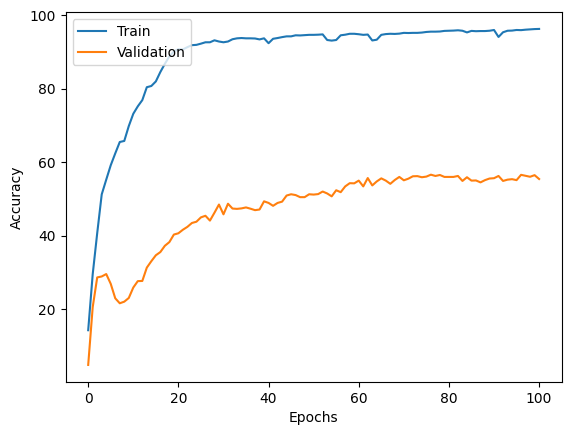

Batch Size: 128, Learning Rate: 0.001, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 21.322314049586776%, Validation Accuracy: 25.874125874125873%
Epoch 10/100 ---> Train Accuracy: 82.52066115702479%, Validation Accuracy: 26.092657342657343%
Epoch 20/100 ---> Train Accuracy: 89.95867768595042%, Validation Accuracy: 43.79370629370629%
Epoch 30/100 ---> Train Accuracy: 92.8099173553719%, Validation Accuracy: 53.01573426573427%
Epoch 40/100 ---> Train Accuracy: 94.95867768595042%, Validation Accuracy: 55.02622377622377%
Epoch 50/100 ---> Train Accuracy: 95.74380165289256%, Validation Accuracy: 57.82342657342657%
Epoch 60/100 ---> Train Accuracy: 96.11570247933884%, Validation Accuracy: 59.52797202797203%
Epoch 70/100 ---> Train Accuracy: 95.70247933884298%, Validation Accuracy: 60.70804195804196%
Epoch 80/100 ---> Train Accuracy: 96.90082644628099%, Validation Accuracy: 61.40734265734266%
Epoch 90/100 ---> Train Accuracy: 96.61157024793388%, Validation Accuracy: 62.76223776223776%
Epoch

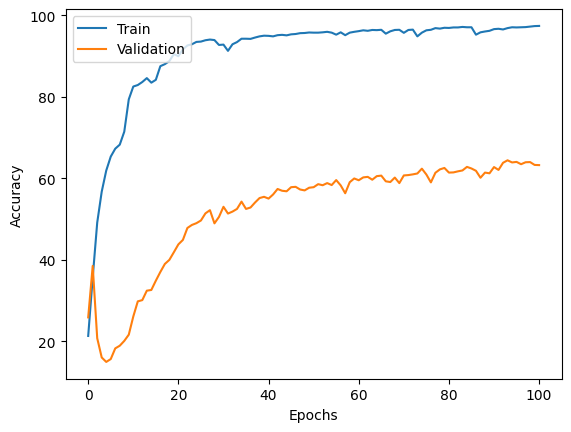

Batch Size: 128, Learning Rate: 0.001, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 50.49586776859504%, Validation Accuracy: 57.25524475524475%
Epoch 10/100 ---> Train Accuracy: 82.02479338842976%, Validation Accuracy: 38.41783216783217%
Epoch 20/100 ---> Train Accuracy: 88.4297520661157%, Validation Accuracy: 54.58916083916084%
Epoch 30/100 ---> Train Accuracy: 95.66115702479338%, Validation Accuracy: 56.42482517482517%
Epoch 40/100 ---> Train Accuracy: 96.52892561983471%, Validation Accuracy: 59.17832167832168%
Epoch 50/100 ---> Train Accuracy: 96.11570247933884%, Validation Accuracy: 59.74650349650349%
Epoch 60/100 ---> Train Accuracy: 97.39669421487604%, Validation Accuracy: 63.76748251748252%
Epoch 70/100 ---> Train Accuracy: 96.32231404958678%, Validation Accuracy: 59.09090909090909%
Epoch 80/100 ---> Train Accuracy: 97.60330578512396%, Validation Accuracy: 64.07342657342657%
Epoch 90/100 ---> Train Accuracy: 98.05785123966942%, Validation Accuracy: 65.20979020979021%
Epoch 10

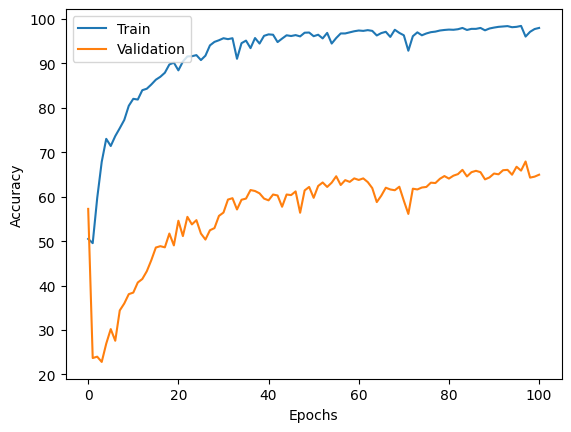

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 54.049586776859506%, Validation Accuracy: 21.547202797202797%
Epoch 10/100 ---> Train Accuracy: 96.03305785123968%, Validation Accuracy: 60.57692307692308%
Epoch 20/100 ---> Train Accuracy: 97.35537190082644%, Validation Accuracy: 66.82692307692308%
Epoch 30/100 ---> Train Accuracy: 97.43801652892562%, Validation Accuracy: 69.14335664335664%
Epoch 40/100 ---> Train Accuracy: 97.60330578512396%, Validation Accuracy: 68.66258741258741%
Epoch 50/100 ---> Train Accuracy: 97.72727272727273%, Validation Accuracy: 69.71153846153847%
Epoch 60/100 ---> Train Accuracy: 98.18181818181819%, Validation Accuracy: 68.61888111888112%
Epoch 70/100 ---> Train Accuracy: 97.97520661157024%, Validation Accuracy: 67.61363636363636%
Epoch 80/100 ---> Train Accuracy: 98.34710743801652%, Validation Accuracy: 70.45454545454545%
Epoch 90/100 ---> Train Accuracy: 98.80165289256199%, Validation Accuracy: 72.29020979020979%
Epoch 

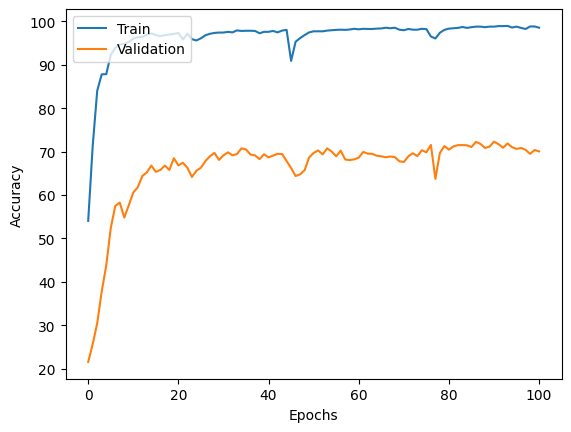

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 66.90082644628099%, Validation Accuracy: 31.861888111888113%
Epoch 10/100 ---> Train Accuracy: 97.39669421487604%, Validation Accuracy: 65.20979020979021%
Epoch 20/100 ---> Train Accuracy: 97.85123966942149%, Validation Accuracy: 68.0506993006993%
Epoch 30/100 ---> Train Accuracy: 97.43801652892562%, Validation Accuracy: 66.25874125874125%
Epoch 40/100 ---> Train Accuracy: 98.59504132231405%, Validation Accuracy: 71.11013986013987%
Epoch 50/100 ---> Train Accuracy: 98.96694214876032%, Validation Accuracy: 70.67307692307692%
Epoch 60/100 ---> Train Accuracy: 99.42148760330579%, Validation Accuracy: 71.63461538461539%
Epoch 70/100 ---> Train Accuracy: 99.29752066115702%, Validation Accuracy: 70.49825174825175%
Epoch 80/100 ---> Train Accuracy: 99.29752066115702%, Validation Accuracy: 70.89160839160839%
Epoch 90/100 ---> Train Accuracy: 99.50413223140495%, Validation Accuracy: 70.45454545454545%
Epoch 10

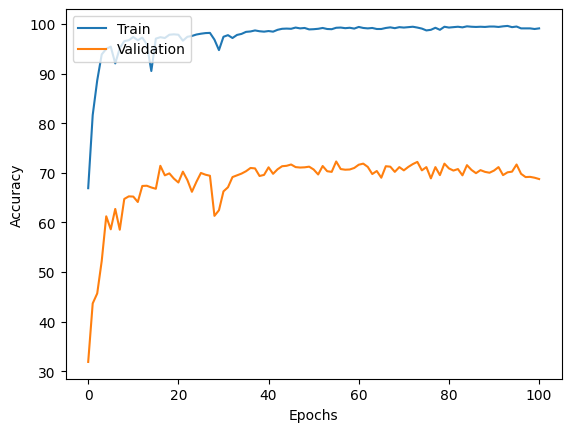

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 74.3801652892562%, Validation Accuracy: 29.632867132867133%
Epoch 10/100 ---> Train Accuracy: 97.14876033057851%, Validation Accuracy: 69.31818181818181%
Epoch 20/100 ---> Train Accuracy: 98.67768595041322%, Validation Accuracy: 70.27972027972028%
Epoch 30/100 ---> Train Accuracy: 98.7603305785124%, Validation Accuracy: 73.07692307692308%
Epoch 40/100 ---> Train Accuracy: 99.21487603305785%, Validation Accuracy: 69.5367132867133%
Epoch 50/100 ---> Train Accuracy: 97.47933884297521%, Validation Accuracy: 68.22552447552448%
Epoch 60/100 ---> Train Accuracy: 99.21487603305785%, Validation Accuracy: 70.23601398601399%
Epoch 70/100 ---> Train Accuracy: 99.17355371900827%, Validation Accuracy: 71.5909090909091%
Epoch 80/100 ---> Train Accuracy: 99.0495867768595%, Validation Accuracy: 72.50874125874125%
Epoch 90/100 ---> Train Accuracy: 99.3801652892562%, Validation Accuracy: 73.03321678321679%
Epoch 100/100

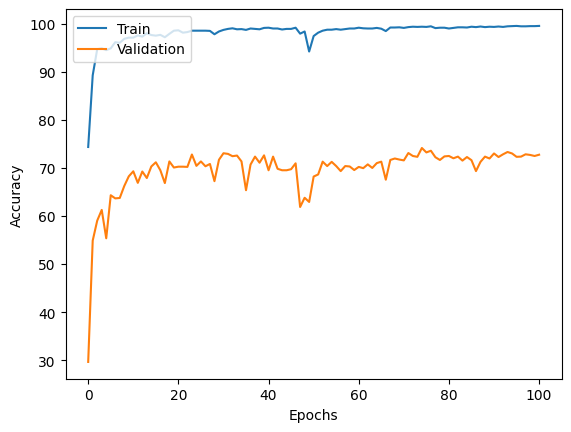

Batch Size: 128, Learning Rate: 0.1, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 88.80165289256199%, Validation Accuracy: 54.67657342657343%
Epoch 10/100 ---> Train Accuracy: 95.74380165289256%, Validation Accuracy: 61.71328671328671%
Epoch 20/100 ---> Train Accuracy: 90.45454545454545%, Validation Accuracy: 52.05419580419581%
Epoch 30/100 ---> Train Accuracy: 64.0495867768595%, Validation Accuracy: 28.146853146853147%
Epoch 40/100 ---> Train Accuracy: 72.68595041322314%, Validation Accuracy: 32.6486013986014%
Epoch 50/100 ---> Train Accuracy: 73.30578512396694%, Validation Accuracy: 28.277972027972027%
Epoch 60/100 ---> Train Accuracy: 71.85950413223141%, Validation Accuracy: 33.78496503496503%
Epoch 70/100 ---> Train Accuracy: 67.76859504132231%, Validation Accuracy: 29.895104895104897%
Epoch 80/100 ---> Train Accuracy: 71.36363636363636%, Validation Accuracy: 34.92132867132867%
Epoch 90/100 ---> Train Accuracy: 74.95867768595042%, Validation Accuracy: 32.34265734265734%
Epoch 10

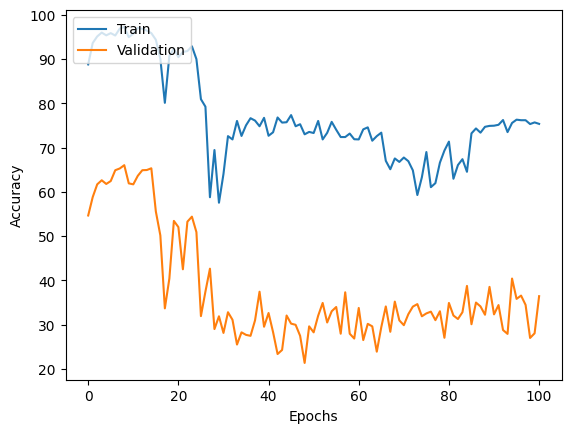

Batch Size: 128, Learning Rate: 0.1, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 90.24793388429752%, Validation Accuracy: 45.67307692307692%
Epoch 10/100 ---> Train Accuracy: 80.74380165289256%, Validation Accuracy: 33.69755244755245%
Epoch 20/100 ---> Train Accuracy: 86.69421487603306%, Validation Accuracy: 46.45979020979021%
Epoch 30/100 ---> Train Accuracy: 77.52066115702479%, Validation Accuracy: 46.41608391608391%
Epoch 40/100 ---> Train Accuracy: 80.78512396694215%, Validation Accuracy: 51.22377622377623%
Epoch 50/100 ---> Train Accuracy: 83.51239669421487%, Validation Accuracy: 44.49300699300699%
Epoch 60/100 ---> Train Accuracy: 74.42148760330579%, Validation Accuracy: 41.34615384615385%
Epoch 70/100 ---> Train Accuracy: 81.28099173553719%, Validation Accuracy: 43.88111888111888%
Epoch 80/100 ---> Train Accuracy: 83.34710743801652%, Validation Accuracy: 48.25174825174825%
Epoch 90/100 ---> Train Accuracy: 80.3305785123967%, Validation Accuracy: 28.715034965034967%
Epoch 100

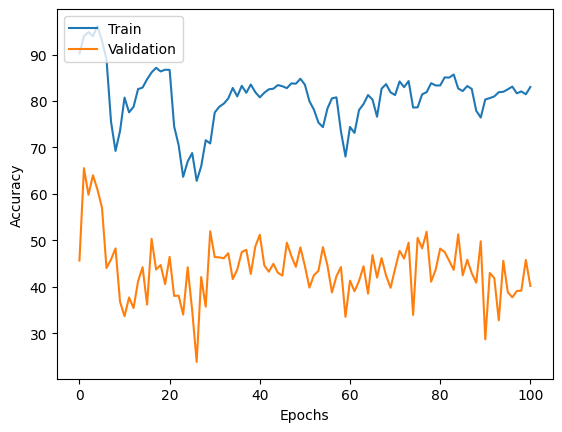

Batch Size: 128, Learning Rate: 0.1, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 84.79338842975207%, Validation Accuracy: 46.67832167832168%
Epoch 10/100 ---> Train Accuracy: 61.65289256198347%, Validation Accuracy: 35.79545454545455%
Epoch 20/100 ---> Train Accuracy: 76.40495867768595%, Validation Accuracy: 45.01748251748252%
Epoch 30/100 ---> Train Accuracy: 80.16528925619835%, Validation Accuracy: 54.8513986013986%
Epoch 40/100 ---> Train Accuracy: 86.07438016528926%, Validation Accuracy: 46.98426573426573%
Epoch 50/100 ---> Train Accuracy: 82.23140495867769%, Validation Accuracy: 50.91783216783217%
Epoch 60/100 ---> Train Accuracy: 84.62809917355372%, Validation Accuracy: 41.12762237762238%
Epoch 70/100 ---> Train Accuracy: 86.52892561983471%, Validation Accuracy: 46.89685314685315%
Epoch 80/100 ---> Train Accuracy: 85.82644628099173%, Validation Accuracy: 41.34615384615385%
Epoch 90/100 ---> Train Accuracy: 86.15702479338843%, Validation Accuracy: 45.32342657342657%
Epoch 100/

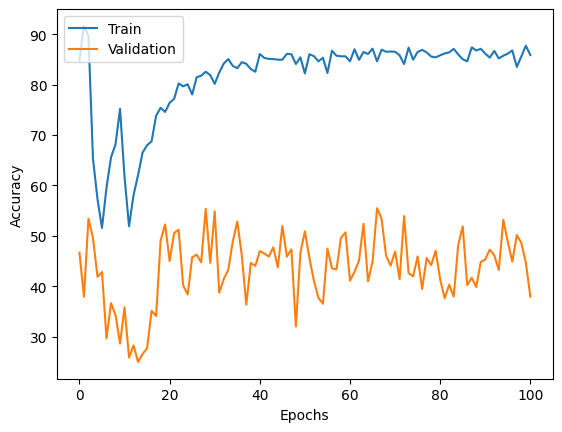

Batch Size: 256, Learning Rate: 0.001, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 11.983471074380166%, Validation Accuracy: 16.564685314685313%
Epoch 10/100 ---> Train Accuracy: 45.66115702479339%, Validation Accuracy: 36.8006993006993%
Epoch 20/100 ---> Train Accuracy: 79.54545454545455%, Validation Accuracy: 35.75174825174825%
Epoch 30/100 ---> Train Accuracy: 82.56198347107438%, Validation Accuracy: 39.72902097902098%
Epoch 40/100 ---> Train Accuracy: 86.5702479338843%, Validation Accuracy: 44.09965034965035%
Epoch 50/100 ---> Train Accuracy: 84.42148760330579%, Validation Accuracy: 46.89685314685315%
Epoch 60/100 ---> Train Accuracy: 87.52066115702479%, Validation Accuracy: 46.63461538461539%
Epoch 70/100 ---> Train Accuracy: 90.9090909090909%, Validation Accuracy: 47.81468531468531%
Epoch 80/100 ---> Train Accuracy: 92.31404958677686%, Validation Accuracy: 49.86888111888112%
Epoch 90/100 ---> Train Accuracy: 93.63636363636364%, Validation Accuracy: 52.53496503496503%
Epoch 10

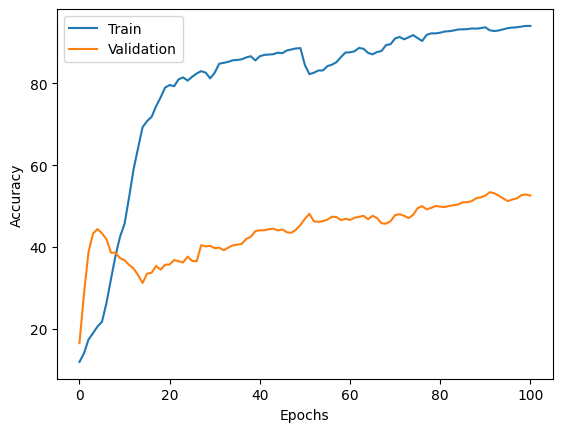

Batch Size: 256, Learning Rate: 0.001, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 16.90082644628099%, Validation Accuracy: 8.304195804195805%
Epoch 10/100 ---> Train Accuracy: 68.55371900826447%, Validation Accuracy: 19.23076923076923%
Epoch 20/100 ---> Train Accuracy: 86.19834710743801%, Validation Accuracy: 35.53321678321678%
Epoch 30/100 ---> Train Accuracy: 89.83471074380165%, Validation Accuracy: 48.68881118881119%
Epoch 40/100 ---> Train Accuracy: 93.88429752066116%, Validation Accuracy: 51.3986013986014%
Epoch 50/100 ---> Train Accuracy: 94.95867768595042%, Validation Accuracy: 56.59965034965035%
Epoch 60/100 ---> Train Accuracy: 95.86776859504133%, Validation Accuracy: 59.22202797202797%
Epoch 70/100 ---> Train Accuracy: 96.07438016528926%, Validation Accuracy: 60.4020979020979%
Epoch 80/100 ---> Train Accuracy: 96.5702479338843%, Validation Accuracy: 62.41258741258741%
Epoch 90/100 ---> Train Accuracy: 97.02479338842976%, Validation Accuracy: 61.66958041958042%
Epoch 100/

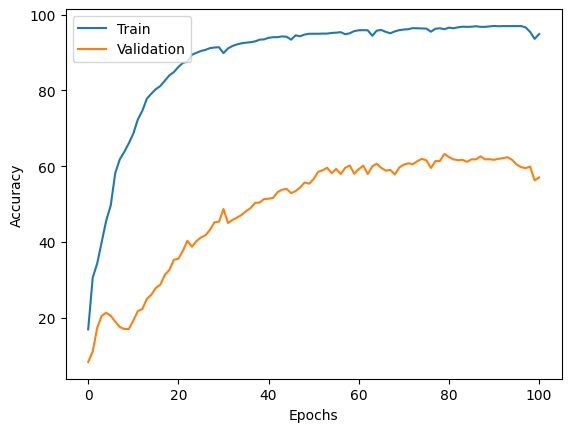

Batch Size: 256, Learning Rate: 0.001, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 43.01652892561984%, Validation Accuracy: 47.77097902097902%
Epoch 10/100 ---> Train Accuracy: 77.64462809917356%, Validation Accuracy: 40.64685314685315%
Epoch 20/100 ---> Train Accuracy: 93.26446280991736%, Validation Accuracy: 55.15734265734266%
Epoch 30/100 ---> Train Accuracy: 94.58677685950413%, Validation Accuracy: 57.08041958041958%
Epoch 40/100 ---> Train Accuracy: 87.52066115702479%, Validation Accuracy: 60.48951048951049%
Epoch 50/100 ---> Train Accuracy: 95.20661157024793%, Validation Accuracy: 57.95454545454545%
Epoch 60/100 ---> Train Accuracy: 95.6198347107438%, Validation Accuracy: 56.9493006993007%
Epoch 70/100 ---> Train Accuracy: 95.04132231404958%, Validation Accuracy: 61.71328671328671%
Epoch 80/100 ---> Train Accuracy: 97.06611570247934%, Validation Accuracy: 62.01923076923077%
Epoch 90/100 ---> Train Accuracy: 97.31404958677686%, Validation Accuracy: 63.02447552447553%
Epoch 100

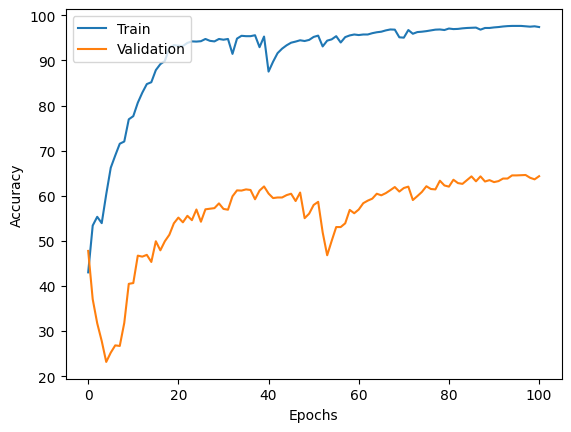

Batch Size: 256, Learning Rate: 0.01, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 49.421487603305785%, Validation Accuracy: 41.78321678321678%
Epoch 10/100 ---> Train Accuracy: 93.4297520661157%, Validation Accuracy: 59.87762237762238%
Epoch 20/100 ---> Train Accuracy: 92.68595041322314%, Validation Accuracy: 54.41433566433567%
Epoch 30/100 ---> Train Accuracy: 96.28099173553719%, Validation Accuracy: 64.33566433566433%
Epoch 40/100 ---> Train Accuracy: 97.35537190082644%, Validation Accuracy: 66.25874125874125%
Epoch 50/100 ---> Train Accuracy: 97.43801652892562%, Validation Accuracy: 65.38461538461539%
Epoch 60/100 ---> Train Accuracy: 97.68595041322314%, Validation Accuracy: 66.56468531468532%
Epoch 70/100 ---> Train Accuracy: 98.09917355371901%, Validation Accuracy: 66.95804195804196%
Epoch 80/100 ---> Train Accuracy: 98.30578512396694%, Validation Accuracy: 66.21503496503496%
Epoch 90/100 ---> Train Accuracy: 98.55371900826447%, Validation Accuracy: 64.5104895104895%
Epoch 100

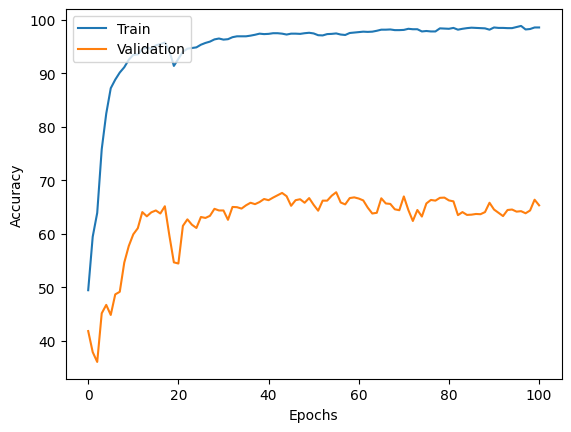

Batch Size: 256, Learning Rate: 0.01, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 54.29752066115702%, Validation Accuracy: 24.86888111888112%
Epoch 10/100 ---> Train Accuracy: 94.54545454545455%, Validation Accuracy: 57.82342657342657%
Epoch 20/100 ---> Train Accuracy: 96.52892561983471%, Validation Accuracy: 63.37412587412587%
Epoch 30/100 ---> Train Accuracy: 97.43801652892562%, Validation Accuracy: 66.6520979020979%
Epoch 40/100 ---> Train Accuracy: 96.5702479338843%, Validation Accuracy: 66.82692307692308%
Epoch 50/100 ---> Train Accuracy: 97.47933884297521%, Validation Accuracy: 70.54195804195804%
Epoch 60/100 ---> Train Accuracy: 98.80165289256199%, Validation Accuracy: 70.1486013986014%
Epoch 70/100 ---> Train Accuracy: 99.29752066115702%, Validation Accuracy: 69.93006993006993%
Epoch 80/100 ---> Train Accuracy: 98.88429752066116%, Validation Accuracy: 69.58041958041959%
Epoch 90/100 ---> Train Accuracy: 98.88429752066116%, Validation Accuracy: 70.8041958041958%
Epoch 100/10

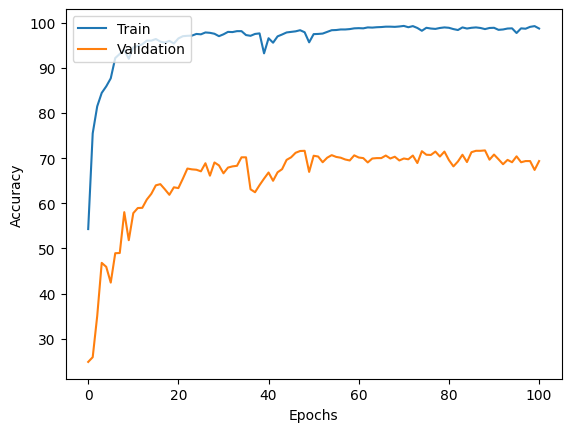

Batch Size: 256, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 63.14049586776859%, Validation Accuracy: 19.58041958041958%
Epoch 10/100 ---> Train Accuracy: 96.5702479338843%, Validation Accuracy: 65.38461538461539%
Epoch 20/100 ---> Train Accuracy: 97.06611570247934%, Validation Accuracy: 65.60314685314685%
Epoch 30/100 ---> Train Accuracy: 95.70247933884298%, Validation Accuracy: 68.18181818181819%
Epoch 40/100 ---> Train Accuracy: 98.88429752066116%, Validation Accuracy: 72.59615384615384%
Epoch 50/100 ---> Train Accuracy: 99.29752066115702%, Validation Accuracy: 71.63461538461539%
Epoch 60/100 ---> Train Accuracy: 98.80165289256199%, Validation Accuracy: 69.88636363636364%
Epoch 70/100 ---> Train Accuracy: 99.00826446280992%, Validation Accuracy: 68.96853146853147%
Epoch 80/100 ---> Train Accuracy: 99.42148760330579%, Validation Accuracy: 69.66783216783217%
Epoch 90/100 ---> Train Accuracy: 99.17355371900827%, Validation Accuracy: 69.66783216783217%
Epoch 100

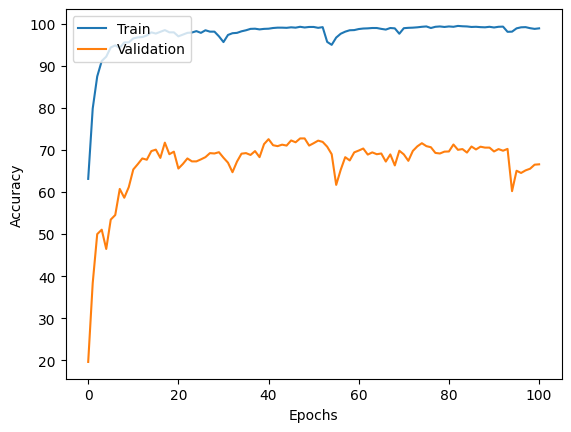

Batch Size: 256, Learning Rate: 0.1, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 77.43801652892562%, Validation Accuracy: 27.534965034965033%
Epoch 10/100 ---> Train Accuracy: 95.04132231404958%, Validation Accuracy: 58.69755244755245%
Epoch 20/100 ---> Train Accuracy: 98.51239669421487%, Validation Accuracy: 66.47727272727273%
Epoch 30/100 ---> Train Accuracy: 89.33884297520662%, Validation Accuracy: 53.88986013986014%
Epoch 40/100 ---> Train Accuracy: 88.26446280991736%, Validation Accuracy: 52.05419580419581%
Epoch 50/100 ---> Train Accuracy: 91.44628099173553%, Validation Accuracy: 44.71153846153846%
Epoch 60/100 ---> Train Accuracy: 81.32231404958678%, Validation Accuracy: 47.81468531468531%
Epoch 70/100 ---> Train Accuracy: 92.8099173553719%, Validation Accuracy: 48.73251748251748%
Epoch 80/100 ---> Train Accuracy: 90.45454545454545%, Validation Accuracy: 44.84265734265734%
Epoch 90/100 ---> Train Accuracy: 92.31404958677686%, Validation Accuracy: 53.49650349650349%
Epoch 100

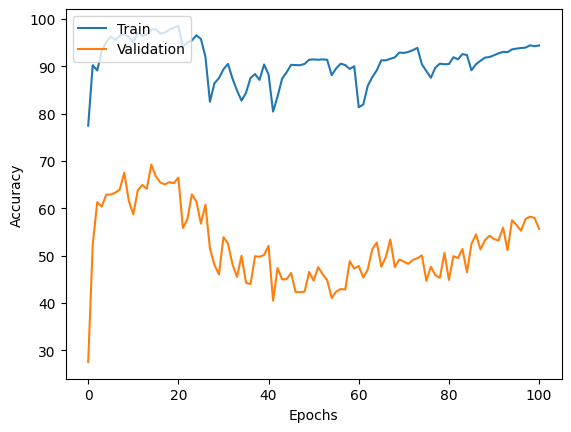

Batch Size: 256, Learning Rate: 0.1, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 81.77685950413223%, Validation Accuracy: 44.71153846153846%
Epoch 10/100 ---> Train Accuracy: 96.73553719008264%, Validation Accuracy: 60.66433566433567%
Epoch 20/100 ---> Train Accuracy: 93.67768595041322%, Validation Accuracy: 53.49650349650349%
Epoch 30/100 ---> Train Accuracy: 60.82644628099174%, Validation Accuracy: 33.30419580419581%
Epoch 40/100 ---> Train Accuracy: 79.46280991735537%, Validation Accuracy: 34.13461538461539%
Epoch 50/100 ---> Train Accuracy: 80.3305785123967%, Validation Accuracy: 38.1993006993007%
Epoch 60/100 ---> Train Accuracy: 67.56198347107438%, Validation Accuracy: 42.74475524475525%
Epoch 70/100 ---> Train Accuracy: 74.46280991735537%, Validation Accuracy: 41.73951048951049%
Epoch 80/100 ---> Train Accuracy: 83.67768595041322%, Validation Accuracy: 44.75524475524475%
Epoch 90/100 ---> Train Accuracy: 79.54545454545455%, Validation Accuracy: 46.37237762237762%
Epoch 100/1

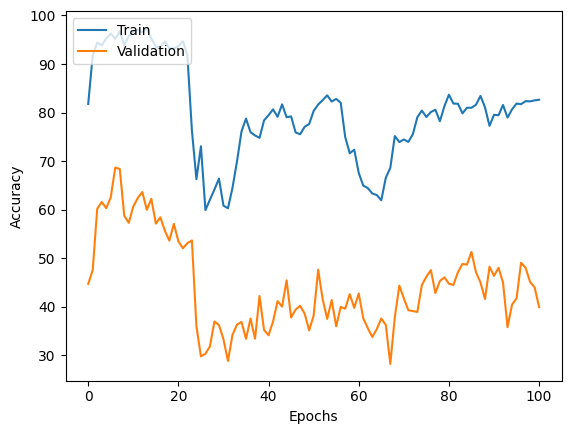

Batch Size: 256, Learning Rate: 0.1, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 86.36363636363636%, Validation Accuracy: 28.802447552447553%
Epoch 10/100 ---> Train Accuracy: 64.0909090909091%, Validation Accuracy: 36.97552447552447%
Epoch 20/100 ---> Train Accuracy: 75.16528925619835%, Validation Accuracy: 29.02097902097902%
Epoch 30/100 ---> Train Accuracy: 70.04132231404958%, Validation Accuracy: 35.88286713286713%
Epoch 40/100 ---> Train Accuracy: 83.96694214876032%, Validation Accuracy: 41.08391608391609%
Epoch 50/100 ---> Train Accuracy: 81.11570247933884%, Validation Accuracy: 40.03496503496503%
Epoch 60/100 ---> Train Accuracy: 65.53719008264463%, Validation Accuracy: 34.00349650349651%
Epoch 70/100 ---> Train Accuracy: 81.98347107438016%, Validation Accuracy: 38.15559440559441%
Epoch 80/100 ---> Train Accuracy: 81.61157024793388%, Validation Accuracy: 40.60314685314685%
Epoch 90/100 ---> Train Accuracy: 77.85123966942149%, Validation Accuracy: 44.40559440559441%
Epoch 100

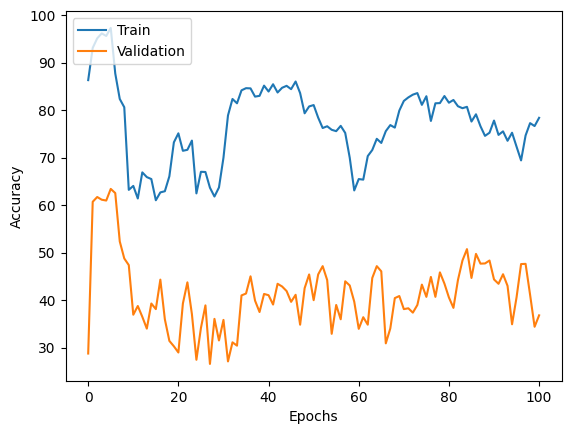

Batch Size: 512, Learning Rate: 0.001, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 12.809917355371901%, Validation Accuracy: 5.1573426573426575%
Epoch 10/100 ---> Train Accuracy: 33.22314049586777%, Validation Accuracy: 14.466783216783217%
Epoch 20/100 ---> Train Accuracy: 50.70247933884298%, Validation Accuracy: 22.115384615384617%
Epoch 30/100 ---> Train Accuracy: 64.79338842975207%, Validation Accuracy: 26.66083916083916%
Epoch 40/100 ---> Train Accuracy: 67.93388429752066%, Validation Accuracy: 28.365384615384617%
Epoch 50/100 ---> Train Accuracy: 74.21487603305785%, Validation Accuracy: 33.39160839160839%
Epoch 60/100 ---> Train Accuracy: 82.97520661157024%, Validation Accuracy: 40.20979020979021%
Epoch 70/100 ---> Train Accuracy: 86.15702479338843%, Validation Accuracy: 43.26923076923077%
Epoch 80/100 ---> Train Accuracy: 86.81818181818181%, Validation Accuracy: 44.53671328671329%
Epoch 90/100 ---> Train Accuracy: 85.78512396694215%, Validation Accuracy: 45.67307692307692%
Ep

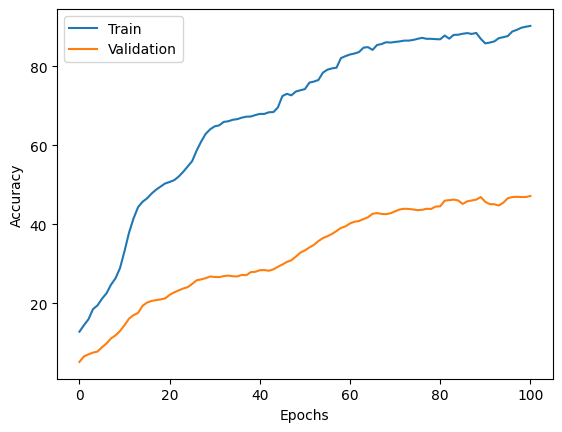

Batch Size: 512, Learning Rate: 0.001, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 15.661157024793388%, Validation Accuracy: 10.13986013986014%
Epoch 10/100 ---> Train Accuracy: 44.83471074380165%, Validation Accuracy: 33.26048951048951%
Epoch 20/100 ---> Train Accuracy: 71.5702479338843%, Validation Accuracy: 29.501748251748253%
Epoch 30/100 ---> Train Accuracy: 84.29752066115702%, Validation Accuracy: 42.13286713286713%
Epoch 40/100 ---> Train Accuracy: 89.95867768595042%, Validation Accuracy: 47.42132867132867%
Epoch 50/100 ---> Train Accuracy: 91.28099173553719%, Validation Accuracy: 48.47027972027972%
Epoch 60/100 ---> Train Accuracy: 92.89256198347107%, Validation Accuracy: 51.18006993006993%
Epoch 70/100 ---> Train Accuracy: 93.67768595041322%, Validation Accuracy: 51.83566433566433%
Epoch 80/100 ---> Train Accuracy: 94.62809917355372%, Validation Accuracy: 55.76923076923077%
Epoch 90/100 ---> Train Accuracy: 95.24793388429752%, Validation Accuracy: 58.12937062937063%
Epoch 

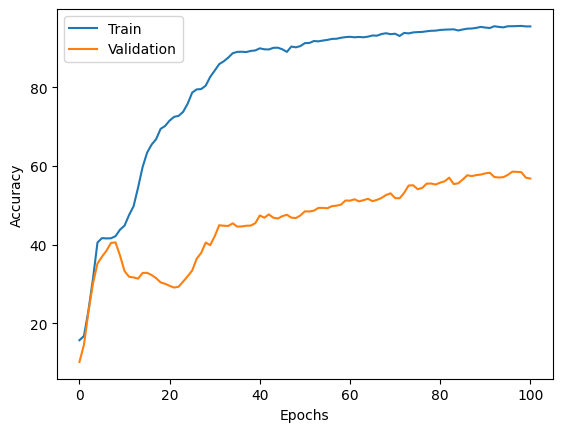

Batch Size: 512, Learning Rate: 0.001, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 17.68595041322314%, Validation Accuracy: 9.047202797202797%
Epoch 10/100 ---> Train Accuracy: 60.99173553719008%, Validation Accuracy: 16.652097902097903%
Epoch 20/100 ---> Train Accuracy: 78.88429752066116%, Validation Accuracy: 32.21153846153846%
Epoch 30/100 ---> Train Accuracy: 86.77685950413223%, Validation Accuracy: 36.1013986013986%
Epoch 40/100 ---> Train Accuracy: 90.41322314049587%, Validation Accuracy: 45.62937062937063%
Epoch 50/100 ---> Train Accuracy: 90.12396694214875%, Validation Accuracy: 48.42657342657343%
Epoch 60/100 ---> Train Accuracy: 92.43801652892562%, Validation Accuracy: 50.91783216783217%
Epoch 70/100 ---> Train Accuracy: 94.25619834710744%, Validation Accuracy: 55.94405594405595%
Epoch 80/100 ---> Train Accuracy: 94.58677685950413%, Validation Accuracy: 56.38111888111888%
Epoch 90/100 ---> Train Accuracy: 96.15702479338843%, Validation Accuracy: 57.56118881118881%
Epoch 1

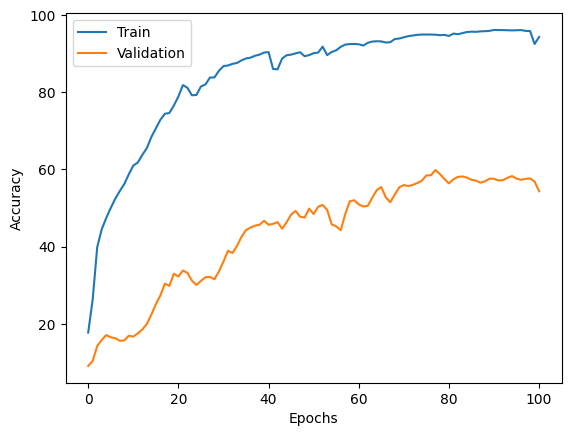

Batch Size: 512, Learning Rate: 0.01, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 40.33057851239669%, Validation Accuracy: 27.70979020979021%
Epoch 10/100 ---> Train Accuracy: 85.6198347107438%, Validation Accuracy: 38.94230769230769%
Epoch 20/100 ---> Train Accuracy: 93.67768595041322%, Validation Accuracy: 50.39335664335665%
Epoch 30/100 ---> Train Accuracy: 95.74380165289256%, Validation Accuracy: 56.07517482517483%
Epoch 40/100 ---> Train Accuracy: 94.29752066115702%, Validation Accuracy: 52.57867132867133%
Epoch 50/100 ---> Train Accuracy: 96.44628099173553%, Validation Accuracy: 59.7027972027972%
Epoch 60/100 ---> Train Accuracy: 96.15702479338843%, Validation Accuracy: 57.82342657342657%
Epoch 70/100 ---> Train Accuracy: 93.55371900826447%, Validation Accuracy: 53.4527972027972%
Epoch 80/100 ---> Train Accuracy: 93.71900826446281%, Validation Accuracy: 55.5506993006993%
Epoch 90/100 ---> Train Accuracy: 95.78512396694215%, Validation Accuracy: 62.58741258741259%
Epoch 100/10

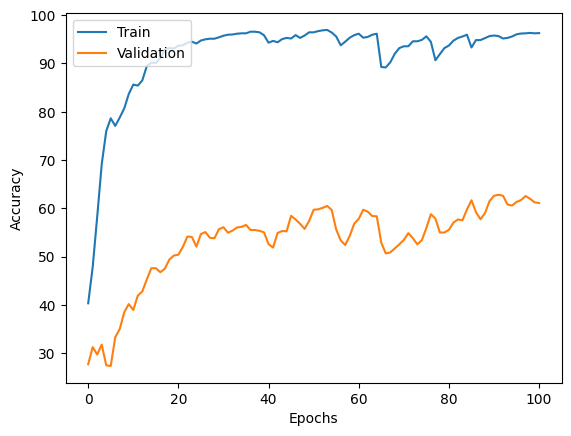

Batch Size: 512, Learning Rate: 0.01, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 28.84297520661157%, Validation Accuracy: 25.874125874125873%
Epoch 10/100 ---> Train Accuracy: 92.97520661157024%, Validation Accuracy: 50.96153846153846%
Epoch 20/100 ---> Train Accuracy: 93.92561983471074%, Validation Accuracy: 60.75174825174825%
Epoch 30/100 ---> Train Accuracy: 96.94214876033058%, Validation Accuracy: 60.22727272727273%
Epoch 40/100 ---> Train Accuracy: 96.48760330578513%, Validation Accuracy: 61.93181818181818%
Epoch 50/100 ---> Train Accuracy: 98.26446280991736%, Validation Accuracy: 66.08391608391608%
Epoch 60/100 ---> Train Accuracy: 98.84297520661157%, Validation Accuracy: 65.55944055944056%
Epoch 70/100 ---> Train Accuracy: 98.4297520661157%, Validation Accuracy: 62.93706293706294%
Epoch 80/100 ---> Train Accuracy: 98.88429752066116%, Validation Accuracy: 66.87062937062937%
Epoch 90/100 ---> Train Accuracy: 99.17355371900827%, Validation Accuracy: 67.22027972027972%
Epoch 10

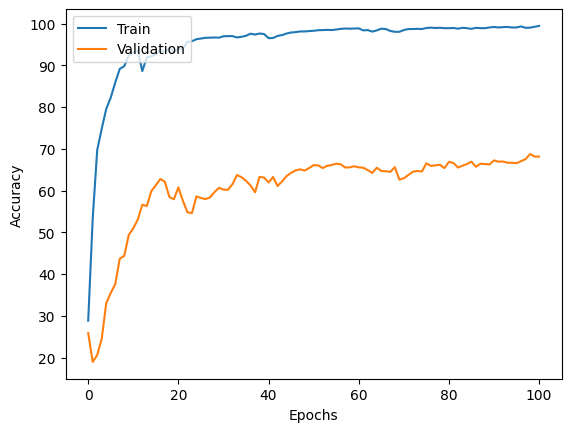

Batch Size: 512, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 49.29752066115702%, Validation Accuracy: 26.791958041958043%
Epoch 10/100 ---> Train Accuracy: 93.51239669421487%, Validation Accuracy: 58.78496503496503%
Epoch 20/100 ---> Train Accuracy: 96.90082644628099%, Validation Accuracy: 63.59265734265734%
Epoch 30/100 ---> Train Accuracy: 97.8099173553719%, Validation Accuracy: 65.51573426573427%
Epoch 40/100 ---> Train Accuracy: 98.67768595041322%, Validation Accuracy: 67.83216783216783%
Epoch 50/100 ---> Train Accuracy: 98.96694214876032%, Validation Accuracy: 68.35664335664336%
Epoch 60/100 ---> Train Accuracy: 98.84297520661157%, Validation Accuracy: 67.04545454545455%
Epoch 70/100 ---> Train Accuracy: 98.18181818181819%, Validation Accuracy: 68.35664335664336%
Epoch 80/100 ---> Train Accuracy: 99.21487603305785%, Validation Accuracy: 69.05594405594405%
Epoch 90/100 ---> Train Accuracy: 99.33884297520662%, Validation Accuracy: 68.61888111888112%
Epoch 10

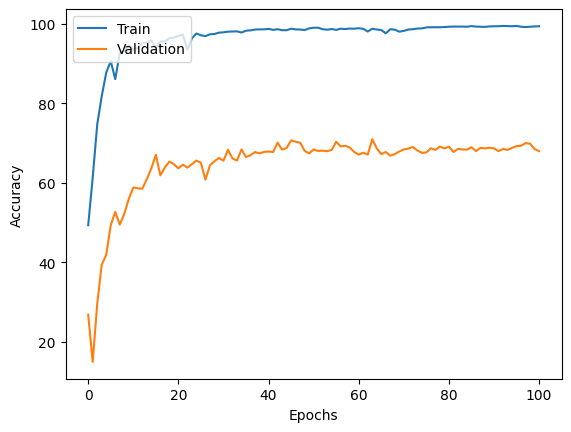

Batch Size: 512, Learning Rate: 0.1, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 67.8099173553719%, Validation Accuracy: 23.382867132867133%
Epoch 10/100 ---> Train Accuracy: 94.95867768595042%, Validation Accuracy: 65.12237762237763%
Epoch 20/100 ---> Train Accuracy: 96.77685950413223%, Validation Accuracy: 66.91433566433567%
Epoch 30/100 ---> Train Accuracy: 97.47933884297521%, Validation Accuracy: 69.84265734265735%
Epoch 40/100 ---> Train Accuracy: 97.76859504132231%, Validation Accuracy: 68.7937062937063%
Epoch 50/100 ---> Train Accuracy: 98.7603305785124%, Validation Accuracy: 67.26398601398601%
Epoch 60/100 ---> Train Accuracy: 95.37190082644628%, Validation Accuracy: 63.8986013986014%
Epoch 70/100 ---> Train Accuracy: 97.64462809917356%, Validation Accuracy: 65.9965034965035%
Epoch 80/100 ---> Train Accuracy: 98.80165289256199%, Validation Accuracy: 67.65734265734265%
Epoch 90/100 ---> Train Accuracy: 98.88429752066116%, Validation Accuracy: 68.22552447552448%
Epoch 100/100

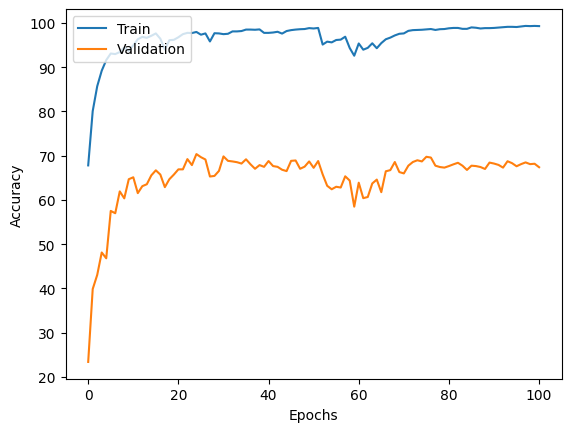

Batch Size: 512, Learning Rate: 0.1, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 77.64462809917356%, Validation Accuracy: 36.84440559440559%
Epoch 10/100 ---> Train Accuracy: 96.85950413223141%, Validation Accuracy: 66.95804195804196%
Epoch 20/100 ---> Train Accuracy: 98.4297520661157%, Validation Accuracy: 66.34615384615384%
Epoch 30/100 ---> Train Accuracy: 98.55371900826447%, Validation Accuracy: 65.20979020979021%
Epoch 40/100 ---> Train Accuracy: 55.90909090909091%, Validation Accuracy: 36.97552447552447%
Epoch 50/100 ---> Train Accuracy: 65.6198347107438%, Validation Accuracy: 42.61363636363637%
Epoch 60/100 ---> Train Accuracy: 71.44628099173553%, Validation Accuracy: 33.74125874125874%
Epoch 70/100 ---> Train Accuracy: 80.9504132231405%, Validation Accuracy: 41.08391608391609%
Epoch 80/100 ---> Train Accuracy: 82.68595041322314%, Validation Accuracy: 40.73426573426573%
Epoch 90/100 ---> Train Accuracy: 81.28099173553719%, Validation Accuracy: 45.23601398601399%
Epoch 100/10

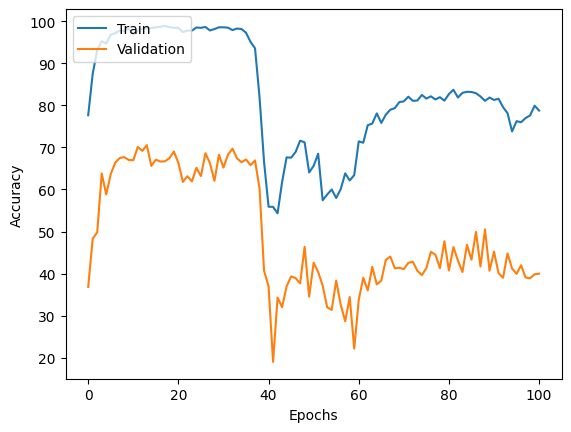

Batch Size: 512, Learning Rate: 0.1, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 73.38842975206612%, Validation Accuracy: 38.28671328671329%
Epoch 10/100 ---> Train Accuracy: 88.7603305785124%, Validation Accuracy: 52.88461538461539%
Epoch 20/100 ---> Train Accuracy: 78.92561983471074%, Validation Accuracy: 38.72377622377623%
Epoch 30/100 ---> Train Accuracy: 66.48760330578513%, Validation Accuracy: 33.87237762237762%
Epoch 40/100 ---> Train Accuracy: 65.16528925619835%, Validation Accuracy: 20.192307692307693%
Epoch 50/100 ---> Train Accuracy: 58.429752066115704%, Validation Accuracy: 35.75174825174825%
Epoch 60/100 ---> Train Accuracy: 74.00826446280992%, Validation Accuracy: 42.22027972027972%
Epoch 70/100 ---> Train Accuracy: 73.67768595041322%, Validation Accuracy: 35.62062937062937%
Epoch 80/100 ---> Train Accuracy: 70.24793388429752%, Validation Accuracy: 39.42307692307692%
Epoch 90/100 ---> Train Accuracy: 83.34710743801652%, Validation Accuracy: 43.18181818181818%
Epoch 10

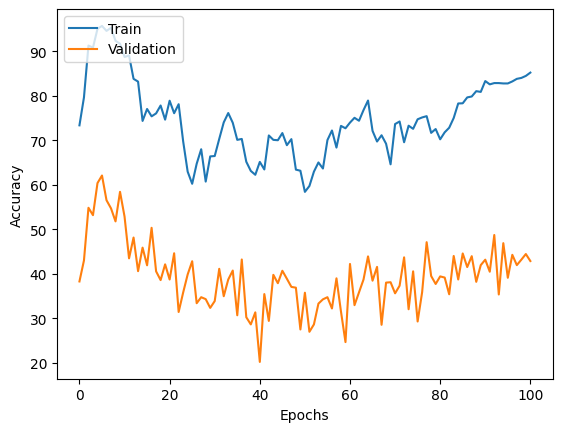

Best Batch Size: 128, Best Learning Rate: 0.01, Best Hidden Layer Dimension Size(?): 64, Resultant Max Accuracy: 72.77097902097903


In [15]:
# Hyperparameter Tuning
EPOCHS = 100
max_acc = 0

for BATCH_SIZE in [64, 128, 256, 512]:
    for LEARNING_RATE in [0.001, 0.01, 0.1]:
        for HIDDEN_DIM in [16, 32, 64]:
            print(f'Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}, Hidden Dim: {HIDDEN_DIM}')
            train_accuracy_list, validation_accuracy_list = modelLoop(EPOCHS, HIDDEN_DIM, LEARNING_RATE, BATCH_SIZE)
            plot_acc(train_accuracy_list, validation_accuracy_list)
            if validation_accuracy_list[-1] > max_acc:
                max_acc = validation_accuracy_list[-1]
                best_tuning = (BATCH_SIZE, LEARNING_RATE, HIDDEN_DIM)
print(f'Best Batch Size: {best_tuning[0]}, Best Learning Rate: {best_tuning[1]}, Best Hidden Layer Dimension Size(?): {best_tuning[2]}, Resultant Max Accuracy: {max_acc}')